In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
import ObsModels
import fun

from FSC import GenerationContinuousObs as FSC_ContinuousObs
from FSC import InferenceContinuousObs as FSC_InferenceContinuousObs

import numba as nb
import pandas as pd

In [3]:
path = "../data/data_filtered"
df = pd.read_csv(path)

In [4]:
cell_indexes = np.unique(df["particle"])
cell_indexes.size

3485

In [5]:
actions = []
frames = []
observations = []

for cell_idx in cell_indexes:
    cell = df[df["particle"] == cell_idx]

    actions.append(cell["tumbling"].values)
    frames.append(cell["frame"].values)
    observations.append(cell["c_norm"].values)

NCutStart = 1000
NCutEnd = 1500

actions = [actions[i] for i in range(NCutStart, NCutEnd)]
frames = [frames[i] for i in range(NCutStart, NCutEnd)]
observations = [observations[i] for i in range(NCutStart, NCutEnd)]

In [6]:
trajectories = []

for i in range(NCutEnd - NCutStart):
    dict_traj = {}
    dict_traj["actions"] = actions[i].astype(int)
    dict_traj["features"] = np.array([np.ones(observations[i].size).astype(np.float32), observations[i].astype(np.float32)])

    trajectories.append(dict_traj)

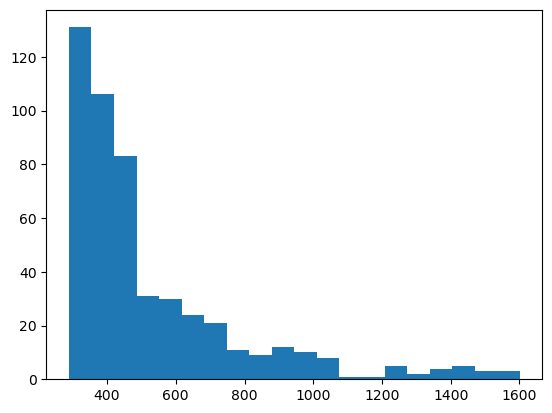

In [7]:
plt.hist([len(tr["actions"]) for tr in trajectories], bins=20)
plt.show()

In [139]:
F = 2
M = 2
A = 2

FSC_tofit = FSC_InferenceContinuousObs(M, A, F, seed = 123)
FSC_tofit.load_trajectories(trajectories)

In [140]:
# %%time
# tloss, vloss = FSC_tofit.optimize(NEpochs = 10, NBatch = 50, lr = 0.05, gamma = 0.99)

In [141]:
# testnum = 0
# par_names = f"../data/parameters/FSC_tofit_M{M}_A{A}_F{F}_test_{testnum}_"

# np.save(par_names + "theta.npy", FSC_tofit.theta.detach().cpu().double().numpy())
# np.save(par_names + "psi.npy", FSC_tofit.psi.detach().cpu().double().numpy())

In [142]:
testnum = 2
par_names = f"../data/parameters/FSC_tofit_M{M}_A{A}_F{F}_test_{testnum}_"


theta = np.load(par_names + "theta.npy")
psi = np.load(par_names + "psi.npy")

In [143]:
FSC_inferred = FSC_ContinuousObs(theta, psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 features.


In [144]:
FSC_inferred.load_features([trajectories[0]["features"]])

(array([163.,  43.,  81., 117., 475.,  64., 133.,  67., 101., 312.]),
 array([0.01174925, 0.01295262, 0.01415598, 0.01535934, 0.01656271,
        0.01776607, 0.01896944, 0.0201728 , 0.02137616, 0.02257952,
        0.02378289]),
 <BarContainer object of 10 artists>)

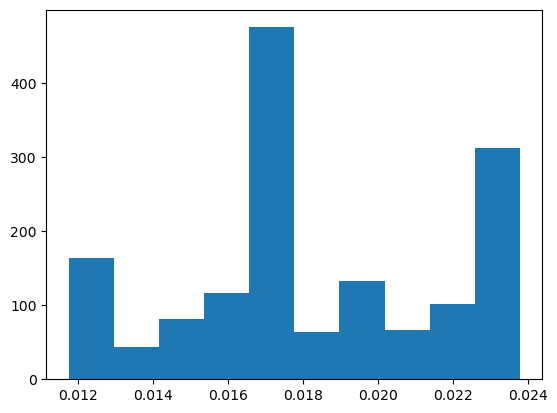

In [162]:
plt.hist(trajectories[0]["features"][1])

In [145]:
NSteps = 1000
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)
Time = np.arange(NSteps)

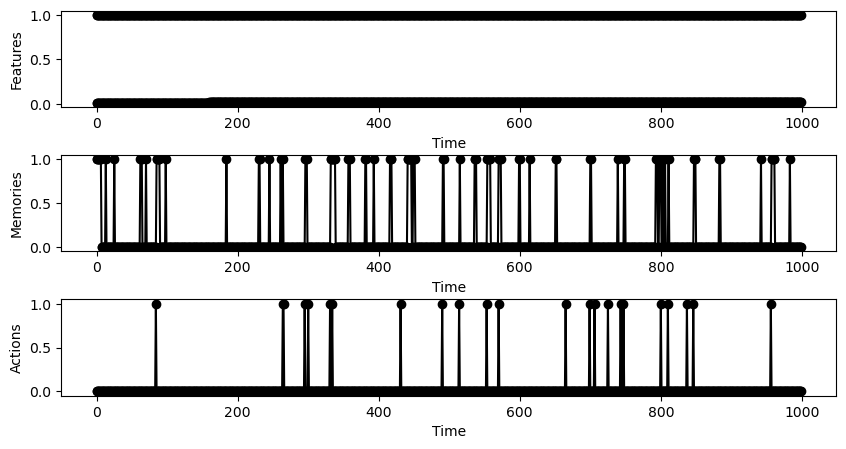

In [146]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

#ax[2].plot(trajectories[idx_trj]["actions"], label = "True", color = "darkred", zorder = -1, alpha = 0.5, lw = 2, ls = "--")

[0.95407606 0.04592394]
[0.40594843 0.59405157]


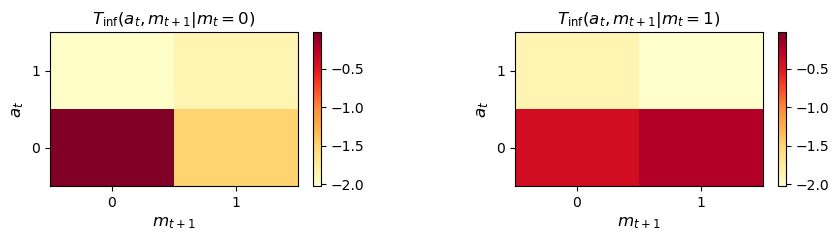

[0.95558354 0.04441646]
[0.40293331 0.59706669]


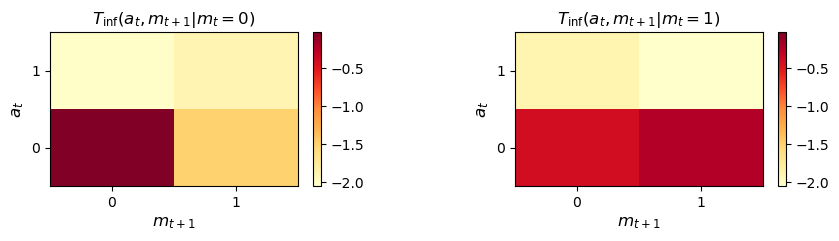

[0.95317695 0.04682305]
[0.40769212 0.59230788]


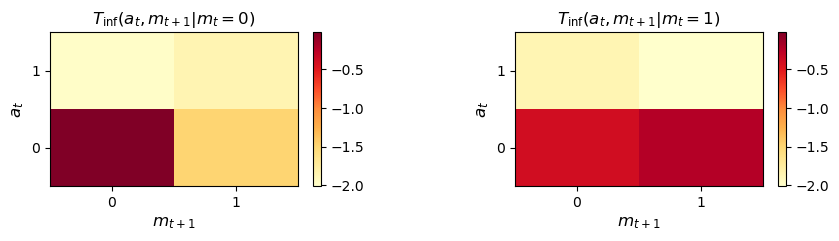

[0.95555848 0.04444152]
[0.40298439 0.59701561]


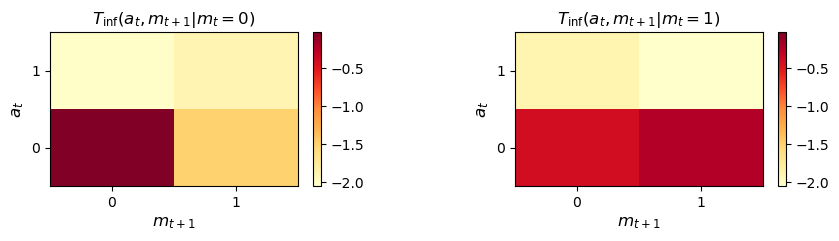

[0.95535777 0.04464223]
[0.4033924 0.5966076]


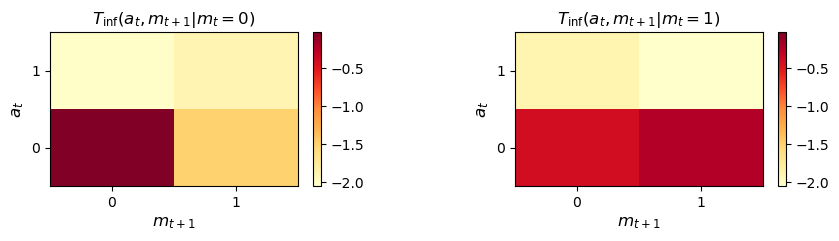

In [151]:
Nfeat_toplot = 5

np.random.seed(0)
idxs_f = np.random.choice(len(trajectories), Nfeat_toplot, replace = False)
t = 20
for idx_f in idxs_f:
    fig, axs = plt.subplots(1, M, figsize=(10,2))
    plt.subplots_adjust(hspace = 0.9, wspace=0.5)
    for a in axs.flatten():
        a.set_xticks(range(M))
        a.set_yticks(range(A))
        a.set_xlabel("$m_{t+1}$", fontsize = 12)
        a.set_ylabel("$a_t$", fontsize = 12)

    feature_test = trajectories[idx_f]["features"][:, t]
    #rint(feature_test)

    TMat_inf = FSC_inferred.get_TMat(feature_test)

    vmin = TMat_inf.min()
    vmax = TMat_inf.max()

    for idx_m, m in enumerate(range(M)):
        im_inf = axs[idx_m].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, np.log10(TMat_inf[idx_m].T),
                                       vmin = np.log10(vmin), vmax = np.log10(vmax), cmap = "YlOrRd")
        
        print(TMat_inf[idx_m].sum(axis = -1))

        axs[idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[idx_m])


    plt.show()

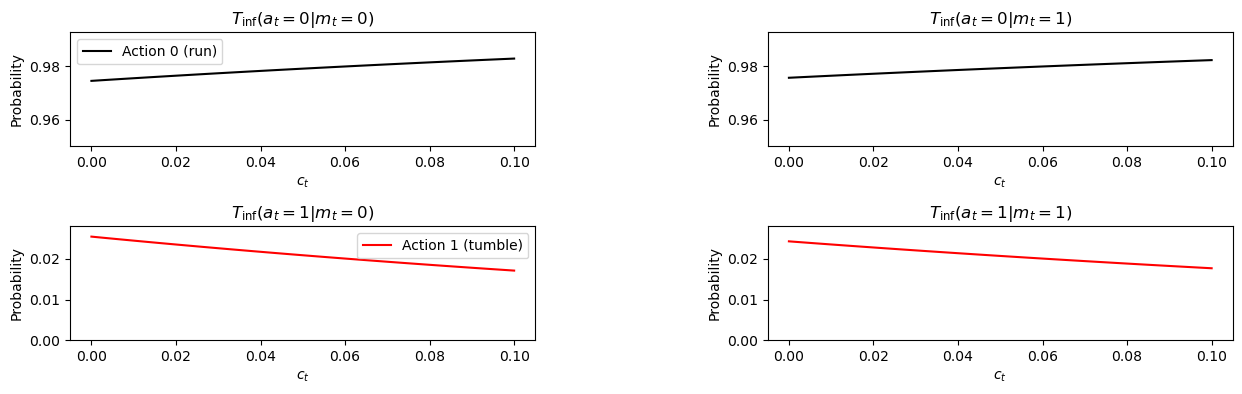

In [164]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

TMats = TMat_array.sum(axis = 2)

fig, ax = plt.subplots(2, M, figsize=(15,4))
plt.subplots_adjust(hspace = 0.7, wspace=0.5)

max_p_0 = TMats[:, :, 0].max()
max_p_1 = TMats[:, :, 1].max()

max_ps = [max_p_0*1.01, max_p_1*1.1]
min_ps = [0.95, 0]

for idx_m, m in enumerate(range(M)):
    ax[0, idx_m].plot(c_array, TMats[:, idx_m, 0], label = f"Action 0 (run)", c = 'k')
    ax[1, idx_m].plot(c_array, TMats[:, idx_m, 1], label = f"Action 1 (tumble)", c = 'r')

    for i in range(2):
        ax[i, idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t = {i} | m_t = {m})$")
        ax[i, idx_m].set_xlabel("$c_t$")
        ax[i, idx_m].set_ylabel("Probability")
        ax[i, idx_m].set_ylim(min_ps[i], max_ps[i])

ax[0, 0].legend()
ax[1, 0].legend()

plt.show()

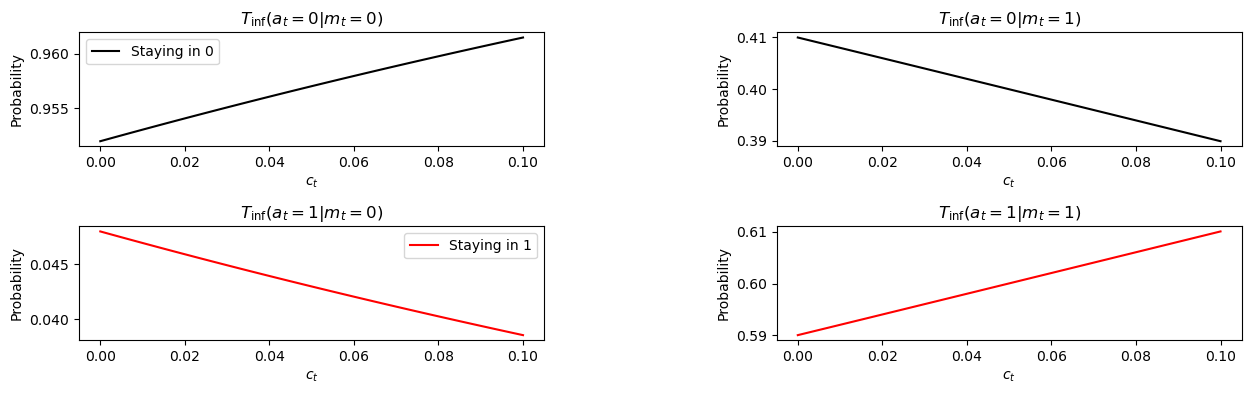

In [163]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

TMats = TMat_array.sum(axis = 3)

fig, ax = plt.subplots(2, M, figsize=(15,4))
plt.subplots_adjust(hspace = 0.7, wspace=0.5)

max_p_0 = TMats[:, :, 0].max()
max_p_1 = TMats[:, :, 1].max()

max_ps = [max_p_0*1.01, max_p_1*1.1]
min_ps = [0.95, 0]

for idx_m, m in enumerate(range(M)):
    ax[0, idx_m].plot(c_array, TMats[:, idx_m, 0], label = f"Staying in 0", c = 'k')
    ax[1, idx_m].plot(c_array, TMats[:, idx_m, 1], label = f"Staying in 1", c = 'r')

    for i in range(2):
        ax[i, idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t = {i} | m_t = {m})$")
        ax[i, idx_m].set_xlabel("$c_t$")
        ax[i, idx_m].set_ylabel("Probability")
        #ax[i, idx_m].set_ylim(min_ps[i], max_ps[i])

ax[0, 0].legend()
ax[1, 0].legend()

plt.show()

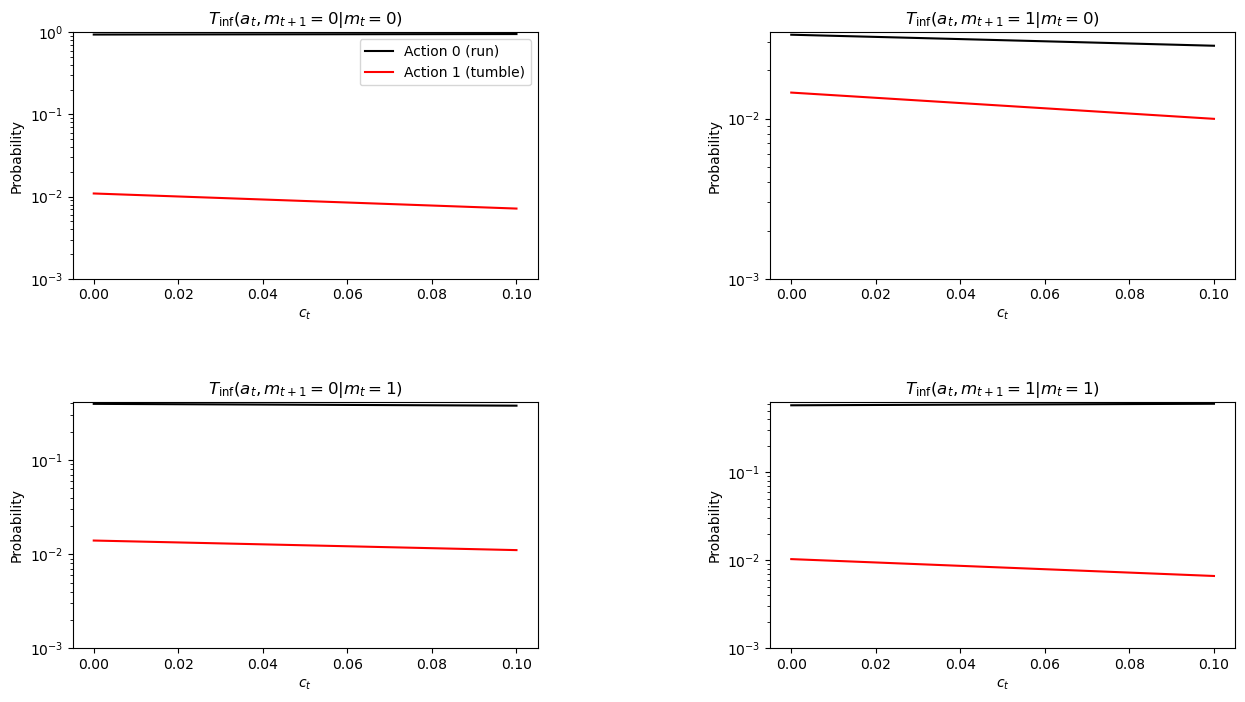

In [153]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

fig, ax = plt.subplots(M, M, figsize=(15,8))
plt.subplots_adjust(hspace = 0.5, wspace=0.5)

for idx_m, m in enumerate(range(M)):
    for idx_m2, m2 in enumerate(range(M)):
        ax[idx_m, idx_m2].plot(c_array, TMat_array[:, idx_m, idx_m2, 0], label = f"Action 0 (run)", c = 'k')
        ax[idx_m, idx_m2].plot(c_array, TMat_array[:, idx_m, idx_m2, 1], label = f"Action 1 (tumble)", c = 'r')

        ax[idx_m, idx_m2].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} = {m2} | m_t = {m})$")
        ax[idx_m, idx_m2].set_xlabel("$c_t$")
        ax[idx_m, idx_m2].set_ylabel("Probability")
        ax[idx_m, idx_m2].set_ylim(1e-3,)
        ax[idx_m, idx_m2].set_yscale('log')

ax[0, 0].legend()

plt.show()

In [127]:
F = 2
M = 3
A = 2

FSC_tofit = FSC_InferenceContinuousObs(M, A, F, seed = 123)
FSC_tofit.load_trajectories(trajectories)

In [128]:
# %%time
# tloss, vloss = FSC_tofit.optimize(NEpochs = 10, NBatch = 50, lr = 0.05, gamma = 0.99)

In [129]:
# testnum = 0
# par_names = f"../data/parameters/FSC_tofit_M{M}_A{A}_F{F}_test_{testnum}_"

# np.save(par_names + "theta.npy", FSC_tofit.theta.detach().cpu().double().numpy())
# np.save(par_names + "psi.npy", FSC_tofit.psi.detach().cpu().double().numpy())

In [131]:
testnum = 0
par_names = f"../data/parameters/FSC_tofit_M{M}_A{A}_F{F}_test_{testnum}_"


theta = np.load(par_names + "theta.npy")
psi = np.load(par_names + "psi.npy")

In [132]:
FSC_inferred = FSC_ContinuousObs(theta, psi, verbose = True)

Initializing FSC with 3 memory states, 2 actions, and 2 features.


In [133]:
FSC_inferred.load_features([trajectories[0]["features"]])

In [134]:
NSteps = 1000
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)
Time = np.arange(NSteps)

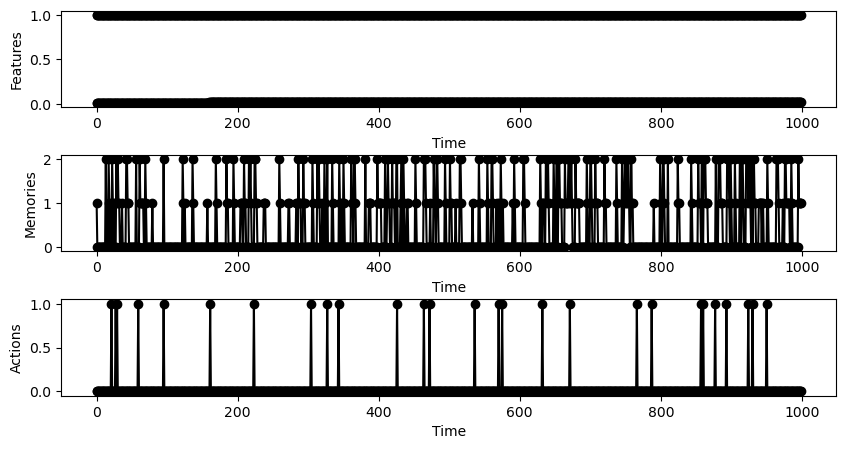

In [135]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

#ax[2].plot(trajectories[idx_trj]["actions"], label = "True", color = "darkred", zorder = -1, alpha = 0.5, lw = 2, ls = "--")

[1.         0.02002613]


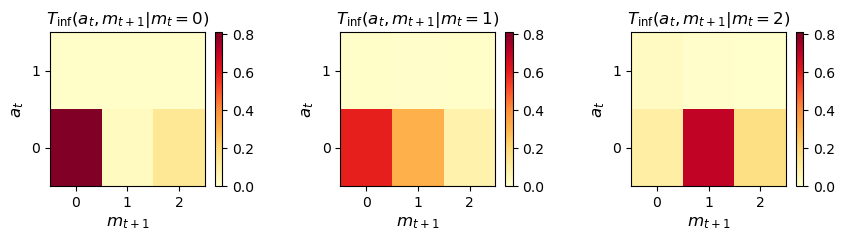

[1.         0.03510767]


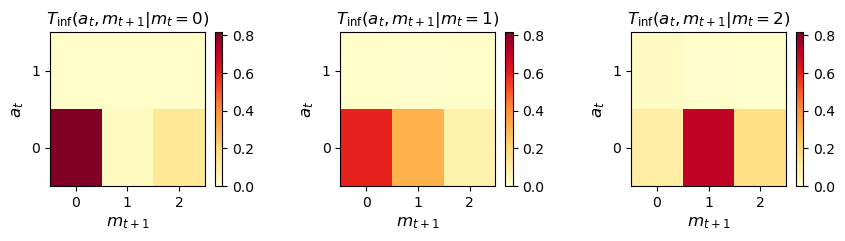

[1.         0.01128964]


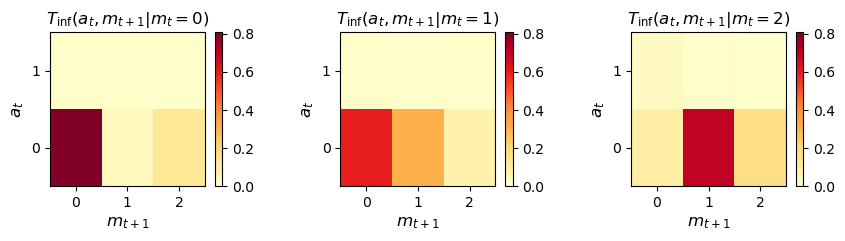

[1.         0.03485238]


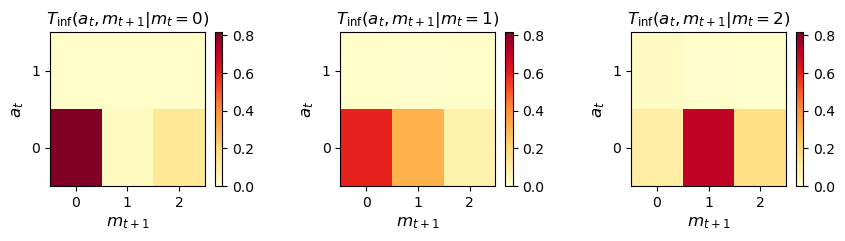

[1.         0.03281313]


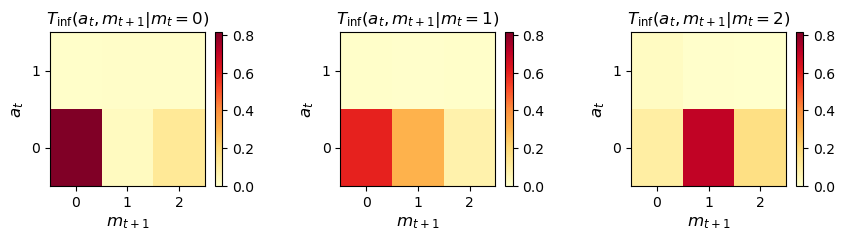

In [136]:
Nfeat_toplot = 5

np.random.seed(0)
idxs_f = np.random.choice(len(trajectories), Nfeat_toplot, replace = False)
t = 20
for idx_f in idxs_f:
    fig, axs = plt.subplots(1, M, figsize=(10,2))
    plt.subplots_adjust(hspace = 0.9, wspace=0.5)
    for a in axs.flatten():
        a.set_xticks(range(M))
        a.set_yticks(range(A))
        a.set_xlabel("$m_{t+1}$", fontsize = 12)
        a.set_ylabel("$a_t$", fontsize = 12)

    feature_test = trajectories[idx_f]["features"][:, t]
    print(feature_test)

    TMat_inf = FSC_inferred.get_TMat(feature_test)

    vmin = TMat_inf.min()
    vmax = TMat_inf.max()

    for idx_m, m in enumerate(range(M)):
        im_inf = axs[idx_m].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, (TMat_inf[idx_m].T),
                                       vmin = (0), vmax = (vmax), cmap = "YlOrRd")

        axs[idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[idx_m])


    plt.show()

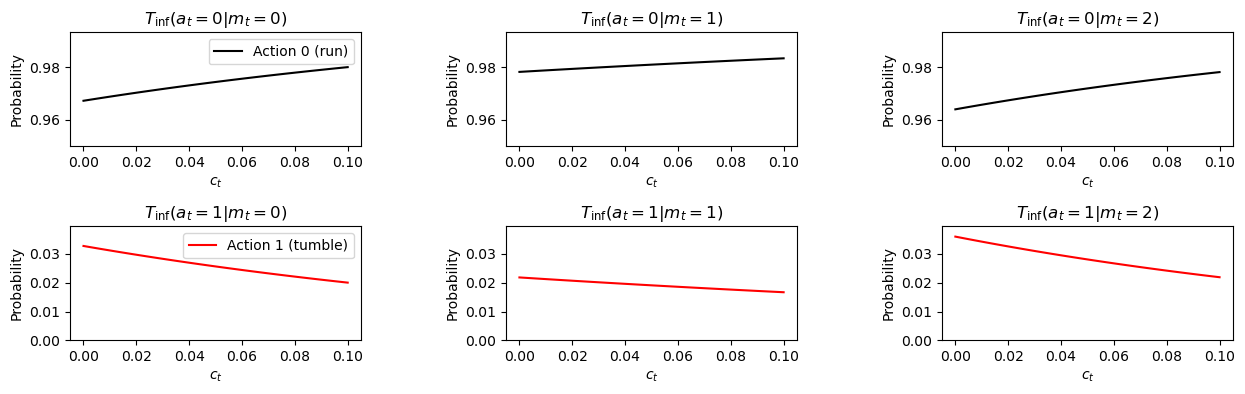

In [137]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

TMats = TMat_array.sum(axis = 2)

fig, ax = plt.subplots(2, M, figsize=(15,4))
plt.subplots_adjust(hspace = 0.7, wspace=0.5)

max_p_0 = TMats[:, :, 0].max()
max_p_1 = TMats[:, :, 1].max()

max_ps = [max_p_0*1.01, max_p_1*1.1]
min_ps = [0.95, 0]

for idx_m, m in enumerate(range(M)):
    ax[0, idx_m].plot(c_array, TMats[:, idx_m, 0], label = f"Action 0 (run)", c = 'k')
    ax[1, idx_m].plot(c_array, TMats[:, idx_m, 1], label = f"Action 1 (tumble)", c = 'r')

    for i in range(2):
        ax[i, idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t = {i} | m_t = {m})$")
        ax[i, idx_m].set_xlabel("$c_t$")
        ax[i, idx_m].set_ylabel("Probability")
        ax[i, idx_m].set_ylim(min_ps[i], max_ps[i])

ax[0, 0].legend()
ax[1, 0].legend()

plt.show()

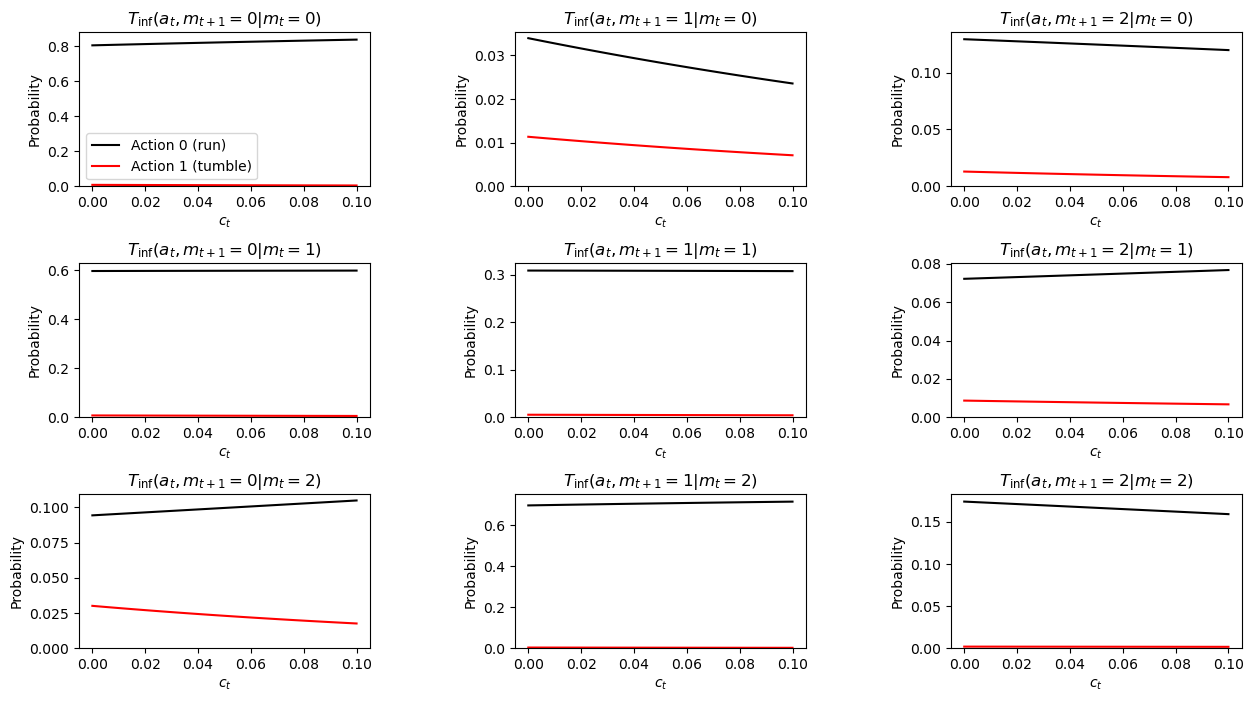

In [138]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

fig, ax = plt.subplots(M, M, figsize=(15,8))
plt.subplots_adjust(hspace = 0.5, wspace=0.5)

for idx_m, m in enumerate(range(M)):
    for idx_m2, m2 in enumerate(range(M)):
        ax[idx_m, idx_m2].plot(c_array, TMat_array[:, idx_m, idx_m2, 0], label = f"Action 0 (run)", c = 'k')
        ax[idx_m, idx_m2].plot(c_array, TMat_array[:, idx_m, idx_m2, 1], label = f"Action 1 (tumble)", c = 'r')

        ax[idx_m, idx_m2].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} = {m2} | m_t = {m})$")
        ax[idx_m, idx_m2].set_xlabel("$c_t$")
        ax[idx_m, idx_m2].set_ylabel("Probability")
        ax[idx_m, idx_m2].set_ylim(0,)

ax[0, 0].legend()

plt.show()

In [ ]:
F = 2
M = 4
A = 2

FSC_tofit = FSC_InferenceContinuousObs(M, A, F, seed = 123)
FSC_tofit.load_trajectories(trajectories)

In [ ]:
# %%time
# tloss, vloss = FSC_tofit.optimize(NEpochs = 10, NBatch = 50, lr = 0.05, gamma = 0.99)

Training with 400 trajectories and validating with 100 trajectories.
Epoch 1 - Training loss: 250.71653076171876, Validation loss: 166.75840515136719 - Learning rate: 0.05
Epoch 2 - Training loss: 144.32466796875, Validation loss: 101.26902290344238 - Learning rate: 0.0495
Epoch 3 - Training loss: 93.87398132324219, Validation loss: 73.58784023284912 - Learning rate: 0.049005
Epoch 4 - Training loss: 72.73871459960938, Validation loss: 62.429259090423585 - Learning rate: 0.04851495
Epoch 5 - Training loss: 64.33560607910155, Validation loss: 57.76409566879273 - Learning rate: 0.0480298005
Epoch 6 - Training loss: 60.65630065917969, Validation loss: 55.72531089782715 - Learning rate: 0.047549502495
Epoch 7 - Training loss: 59.01073974609375, Validation loss: 54.772634258270266 - Learning rate: 0.04707400747005
Epoch 8 - Training loss: 58.233862304687506, Validation loss: 54.29372531890869 - Learning rate: 0.0466032673953495
Epoch 9 - Training loss: 57.80159606933593, Validation loss: 54

In [ ]:
# testnum = 0
# par_names = f"../data/parameters/FSC_tofit_M{M}_A{A}_F{F}_test_{testnum}_"

# np.save(par_names + "theta.npy", FSC_tofit.theta.detach().cpu().double().numpy())
# np.save(par_names + "psi.npy", FSC_tofit.psi.detach().cpu().double().numpy())

In [ ]:
testnum = 2
par_names = f"../data/parameters/FSC_tofit_M{M}_A{A}_F{F}_test_{testnum}_"


theta = np.load(par_names + "theta.npy")
psi = np.load(par_names + "psi.npy")

In [ ]:
FSC_inferred = FSC_ContinuousObs(theta, psi, verbose = True)

Initializing FSC with 4 memory states, 2 actions, and 2 features.


In [ ]:
FSC_inferred.load_features([trajectories[0]["features"]])

In [ ]:
NSteps = 1000
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)
Time = np.arange(NSteps)

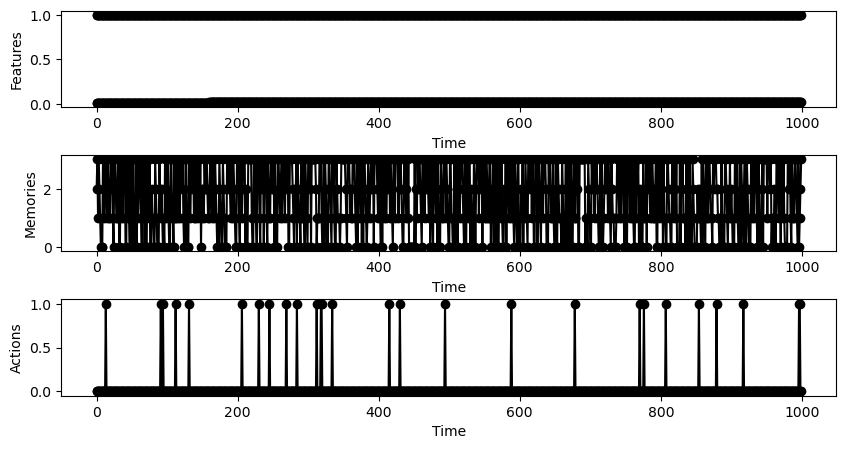

In [ ]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

#ax[2].plot(trajectories[idx_trj]["actions"], label = "True", color = "darkred", zorder = -1, alpha = 0.5, lw = 2, ls = "--")

[1.         0.02002613]


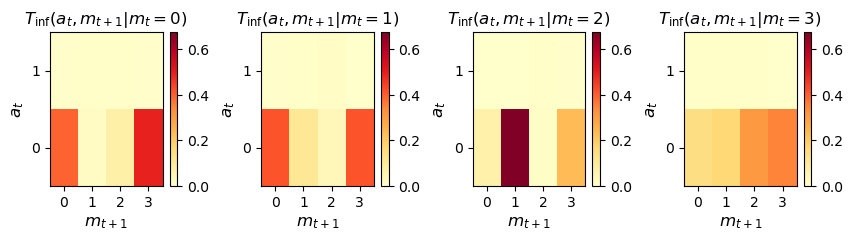

[1.         0.03510767]


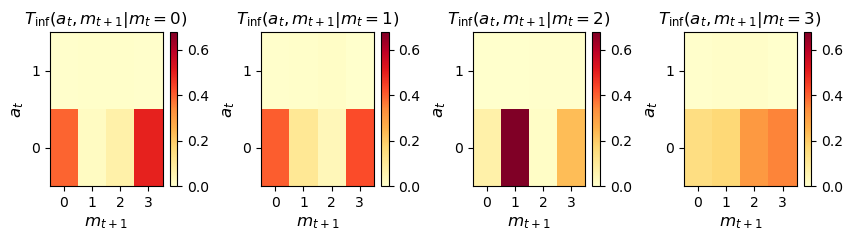

[1.         0.01128964]


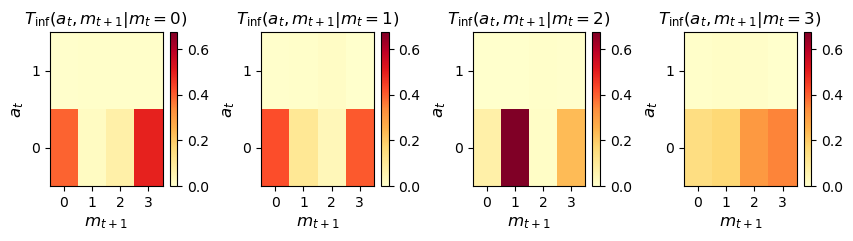

[1.         0.03485238]


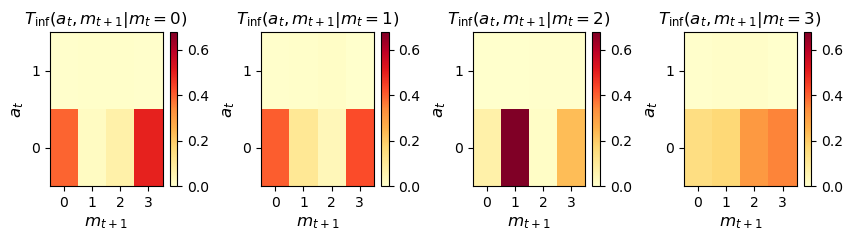

[1.         0.03281313]


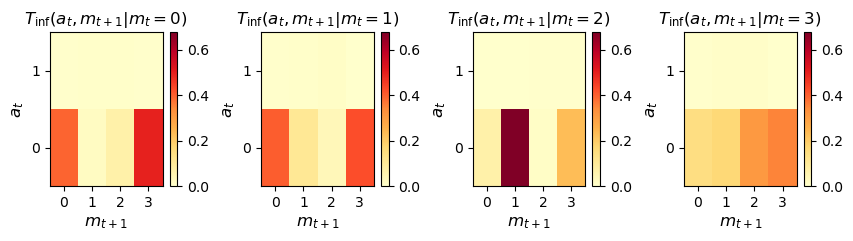

In [ ]:
Nfeat_toplot = 5

np.random.seed(0)
idxs_f = np.random.choice(len(trajectories), Nfeat_toplot, replace = False)
t = 20
for idx_f in idxs_f:
    fig, axs = plt.subplots(1, M, figsize=(10,2))
    plt.subplots_adjust(hspace = 0.9, wspace=0.5)
    for a in axs.flatten():
        a.set_xticks(range(M))
        a.set_yticks(range(A))
        a.set_xlabel("$m_{t+1}$", fontsize = 12)
        a.set_ylabel("$a_t$", fontsize = 12)

    feature_test = trajectories[idx_f]["features"][:, t]
    print(feature_test)

    TMat_inf = FSC_inferred.get_TMat(feature_test)

    vmin = TMat_inf.min()
    vmax = TMat_inf.max()

    for idx_m, m in enumerate(range(M)):
        im_inf = axs[idx_m].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, (TMat_inf[idx_m].T),
                                       vmin = (0), vmax = (vmax), cmap = "YlOrRd")

        axs[idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[idx_m])


    plt.show()

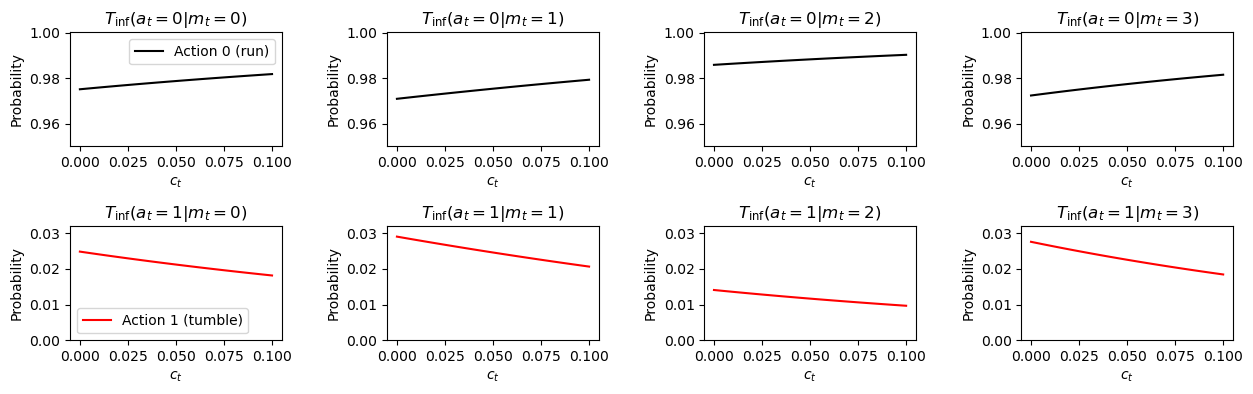

In [ ]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

TMats = TMat_array.sum(axis = 2)

fig, ax = plt.subplots(2, M, figsize=(15,4))
plt.subplots_adjust(hspace = 0.7, wspace=0.5)

max_p_0 = TMats[:, :, 0].max()
max_p_1 = TMats[:, :, 1].max()

max_ps = [max_p_0*1.01, max_p_1*1.1]
min_ps = [0.95, 0]

for idx_m, m in enumerate(range(M)):
    ax[0, idx_m].plot(c_array, TMats[:, idx_m, 0], label = f"Action 0 (run)", c = 'k')
    ax[1, idx_m].plot(c_array, TMats[:, idx_m, 1], label = f"Action 1 (tumble)", c = 'r')

    for i in range(2):
        ax[i, idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t = {i} | m_t = {m})$")
        ax[i, idx_m].set_xlabel("$c_t$")
        ax[i, idx_m].set_ylabel("Probability")
        ax[i, idx_m].set_ylim(min_ps[i], max_ps[i])

ax[0, 0].legend()
ax[1, 0].legend()

plt.show()

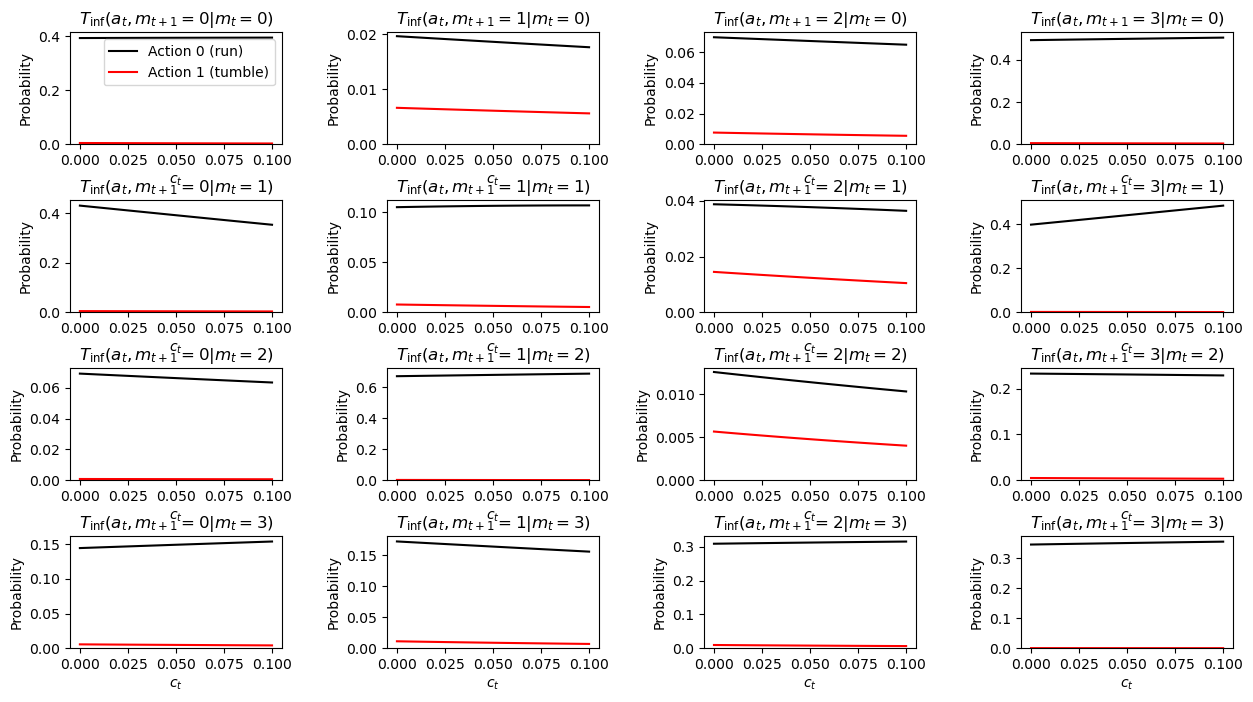

In [ ]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

fig, ax = plt.subplots(M, M, figsize=(15,8))
plt.subplots_adjust(hspace = 0.5, wspace=0.5)

for idx_m, m in enumerate(range(M)):
    for idx_m2, m2 in enumerate(range(M)):
        ax[idx_m, idx_m2].plot(c_array, TMat_array[:, idx_m, idx_m2, 0], label = f"Action 0 (run)", c = 'k')
        ax[idx_m, idx_m2].plot(c_array, TMat_array[:, idx_m, idx_m2, 1], label = f"Action 1 (tumble)", c = 'r')

        ax[idx_m, idx_m2].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} = {m2} | m_t = {m})$")
        ax[idx_m, idx_m2].set_xlabel("$c_t$")
        ax[idx_m, idx_m2].set_ylabel("Probability")
        ax[idx_m, idx_m2].set_ylim(0,)

ax[0, 0].legend()

plt.show()